# Base Model QED
This is the base setup for working on QED data.
It shows how to import the data and how to convert the expressions into different formats.

In [5]:
from icecream import ic
import sympy as sp
from itertools import (takewhile,repeat)
from tqdm import tqdm
import numpy as np
import sys
import importlib.util
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow import keras
import pickle

In [2]:
tf.config.list_physical_devices('GPU')

2022-10-11 17:53:13.632629: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-11 17:53:13.636276: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-11 17:53:13.636408: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
spec = importlib.util.spec_from_file_location("SympyPrefix", "../sympy-prefix/source/SympyPrefix.py")
SympyPrefix = importlib.util.module_from_spec(spec)
sys.modules["SympyPrefix"] = SympyPrefix
spec.loader.exec_module(SympyPrefix)
prefix_to_sympy = SympyPrefix.prefix_to_sympy
sympy_to_prefix = SympyPrefix.sympy_to_prefix
sympy_to_hybrid_prefix = SympyPrefix.sympy_to_hybrid_prefix
hybrid_prefix_to_sympy = SympyPrefix.hybrid_prefix_to_sympy

spec = importlib.util.spec_from_file_location("sp2tree", "../data-preprocessing/tree/sympy_to_tree.py")
sp2tree = importlib.util.module_from_spec(spec)
sys.modules["SympyTree"] = sp2tree
spec.loader.exec_module(sp2tree)

spec = importlib.util.spec_from_file_location("symba_utilities", "../conversions.py")
symba_utilities = importlib.util.module_from_spec(spec)
sys.modules["symba_utilities"] = symba_utilities
# spec.loader.exec_module(utilities)

In [4]:
import re
def fix_i(expr_str):
    reg_ex = "[^a-z]i[^a-z,^\d]"
    replaced = re.sub(reg_ex, fix_i_match, expr_str)
    return replaced
    
def fix_i_match(matchobj):
    """
    i --> I
    """
    match = matchobj.group(0)
    return match.replace("i", "I")


def rawincount(filename):
    """count numer of lines in a file. 
    From https://stackoverflow.com/questions/845058/how-to-get-line-count-of-a-large-file-cheaply-in-python
    """
    f = open(filename, 'rb')
    bufgen = takewhile(lambda x: x, (f.raw.read(1024*1024) for _ in repeat(None)))
    return sum( buf.count(b'\n') for buf in bufgen )

def load_raw_amplitudes(filename, max_lines=-1):
    """
    Loading raw amplitudes from filename.
    
    Options:
        - `max_lines`: maximum number of lines to read
    """
    print("Loading amplitudes from "+ filename)
    if max_lines > 0:
        number_of_lines = max_lines
    else:
        number_of_lines = rawincount(filename)
    data = [0 for i in range(number_of_lines-1)]
    pbar = tqdm(total=number_of_lines)
    with open(filename) as f:
        line = f.readline()
        ctr = 0
        data[ctr] = line.replace("\n", "")
        while line:
            line = f.readline()
            if line != "":
                data[ctr] = line.replace("\n", "")
            pbar.update(1)
            ctr = ctr + 1
            if ctr >= number_of_lines:
                break
    pbar.close()
    return data


def load_squared_amplitudes(filename, max_lines=-1):
    """
    Loading squared amplitudes from filename and parsing into sympy.
    All squared amplitudes should be exportet from sympy and thus be readable
    without any preprocessing.

    Options:
        - `max_lines`: maximum number of lines to read

    Returns:
        list of squared amplitudes, each as a sympy expression
    """
    print("Loading squared amplitudes from "+ filename)
    if max_lines > 0:
        number_of_lines = max_lines
    else:
        number_of_lines = rawincount(filename)
    data = [0 for i in range(number_of_lines-1)]
    pbar = tqdm(total=number_of_lines)
    with open(filename) as f:
       line = f.readline()
       line_sp = sp.sympify(line.strip())
       ctr = 0
       data[ctr] = line_sp
       while line:
            line = f.readline()
            if line != "":
                line = line.strip()
                line = fix_i(line)
                line_sp = sp.sympify(line.strip())
                data[ctr] = line_sp
            pbar.update(1)
            ctr = ctr + 1
            if ctr >= number_of_lines:
                break
    pbar.close()
    return data

In [6]:
data_folder = "../raw_data.nosync/"
amplitudes_filename_start = "QED_amplitudes_TreeLevel_"
sqamplitudes_filename_start = "QED_sqamplitudes_TreeLevel_"
processes = ["1to2", "2to1", "2to2", "2to3", "3to2"]
max_lines = -1

amplitudes = []
sqamplitudes = []
for process in processes:
    ampl_f = data_folder + amplitudes_filename_start + process + ".txt"
    sqampl_f = data_folder + sqamplitudes_filename_start + process + ".txt"
    amplitudes_process = load_raw_amplitudes(ampl_f, max_lines=max_lines)
    sqamplitudes_process = load_squared_amplitudes(sqampl_f, max_lines=max_lines)
    amplitudes.append(amplitudes_process)
    sqamplitudes.append(sqamplitudes_process)

Loading amplitudes from ../raw_data.nosync/QED_amplitudes_TreeLevel_1to2.txt


  0%|          | 0/432 [00:00<?, ?it/s]

Loading squared amplitudes from ../raw_data.nosync/QED_sqamplitudes_TreeLevel_1to2.txt


  0%|          | 0/432 [00:00<?, ?it/s]

Loading amplitudes from ../raw_data.nosync/QED_amplitudes_TreeLevel_2to1.txt


  0%|          | 0/432 [00:00<?, ?it/s]

Loading squared amplitudes from ../raw_data.nosync/QED_sqamplitudes_TreeLevel_2to1.txt


  0%|          | 0/432 [00:00<?, ?it/s]

Loading amplitudes from ../raw_data.nosync/QED_amplitudes_TreeLevel_2to2.txt


  0%|          | 0/10944 [00:00<?, ?it/s]

Loading squared amplitudes from ../raw_data.nosync/QED_sqamplitudes_TreeLevel_2to2.txt


  0%|          | 0/10944 [00:00<?, ?it/s]

Loading amplitudes from ../raw_data.nosync/QED_amplitudes_TreeLevel_2to3.txt


  0%|          | 0/129024 [00:00<?, ?it/s]

Loading squared amplitudes from ../raw_data.nosync/QED_sqamplitudes_TreeLevel_2to3.txt


  0%|          | 0/129024 [00:00<?, ?it/s]

KeyboardInterrupt: 

We will keep the different amplitudes separated for now, so `amplitudes` has the form
`[multiplicity, i]` where `multiplicity = ["1to2", "2to1", ...]`.

In [49]:
# the amplitudes are in prefix format
print(len(amplitudes))
print(len(sqamplitudes))

3
3


In [50]:
amplitudes[0][0]

'Prod,-1,Prod,i,Prod,e,Prod,gamma,alpha_2,alpha_0,alpha_1,Prod,A^(*),i_2,alpha_2,(p_3),Prod,mu,i_0,alpha_1,(p_1)_u,mu^(*),i_1,alpha_0,(p_2)_u'

In [51]:
sqamplitudes[0][0]

-4*e**2*(2*m_mu**2 - s_12)

In [52]:
# convert squared ampmlitudes to prefix
ctr = 0
def try_sympy_to_prefix(expr):
    global ctr
    ctr = ctr + 1
    try:
        return sympy_to_prefix(expr)
    except:
        print("problem with:", expr, "at ctr =", ctr)
        return 0
sqampl_prefix = [[try_sympy_to_prefix(a) for a in tqdm(sq)] for sq in sqamplitudes]
np.array(sqampl_prefix[0][0])

  0%|          | 0/431 [00:00<?, ?it/s]

  0%|          | 0/431 [00:00<?, ?it/s]

  0%|          | 0/10943 [00:00<?, ?it/s]

array(['mul', 's-', '4', 'mul', 'pow', 'e', '2', 'add', 'mul', 's-', '1',
       's_12', 'mul', '2', 'pow', 'm_mu', '2'], dtype='<U4')

  0%|          | 0/431 [00:00<?, ?it/s]

  0%|          | 0/431 [00:00<?, ?it/s]

  0%|          | 0/10943 [00:00<?, ?it/s]

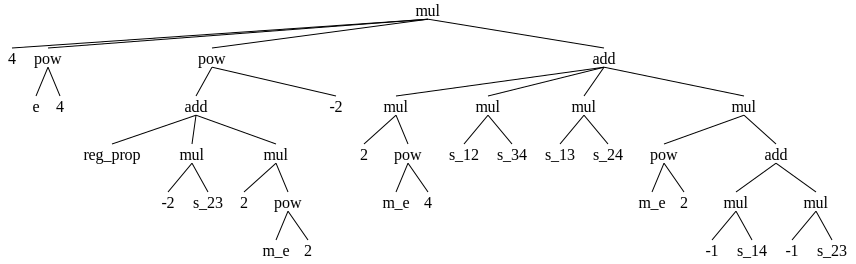

In [53]:
# convert squared amplitudes to trees:
ctr = 0
def try_sympy_to_tree(expr):
    global ctr
    ctr = ctr + 1
    try:
        return sp2tree.sympy_to_tree(expr)
    except:
        print("problem with:", expr, "at ctr =", ctr)
        return 0
sqampl_tree = [[try_sympy_to_tree(a) for a in tqdm(sq)] for sq in sqamplitudes]
sqampl_tree[2][0]

In this base model we will be using prefix notation for the amplitudes and squared amplitudes

In [55]:
X_train = []
X_test = []
y_train = []
y_test = []
X_val = []
y_val = []
X_tmp = []
y_tmp = []
for a, s in zip(amplitudes, sqampl_prefix):
    X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
        a, s, test_size=0.1, random_state=42
    )
    X_train = X_train + X_train_i
    X_tmp = X_tmp + X_test_i
    y_train = y_train + y_train_i
    y_tmp = y_tmp + y_test_i

X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
    X_tmp, y_tmp, test_size=0.5, random_state=42
)
X_val = X_val + X_train_i
X_test = X_test + X_test_i
y_val = y_val + y_train_i
y_test = y_test + y_test_i

del X_tmp, y_tmp

In [56]:
print(len(X_train))
print(len(y_train))
print(len(X_val))
print(len(y_val))
print(len(X_test))
print(len(y_test))


10622
10622
591
591
592
592


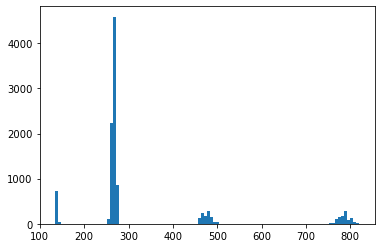

In [57]:
plt.hist([len(x) for x in X_train], bins=100);

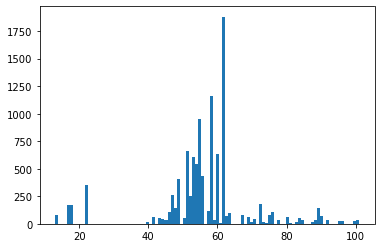

In [58]:
plt.hist([len(y) for y in y_train], bins=100);

Only use those X,y where both are at most `sequence_length` long.

In [59]:
vocab_size = 500
sequence_length = 350
batch_size = 1

X_train_idx_okay = np.where([len(x) < sequence_length for x in X_train])[0]
y_train_idx_okay = np.where([len(y) < sequence_length for y in y_train])[0]
X_val_idx_okay = np.where([len(x) < sequence_length for x in X_val])[0]
y_val_idx_okay = np.where([len(x) < sequence_length for x in y_val])[0]
X_test_idx_okay = np.where([len(x) < sequence_length for x in X_test])[0]
y_test_idx_okay = np.where([len(x) < sequence_length for x in y_test])[0]


train_idx_okay = np.intersect1d(X_train_idx_okay, y_train_idx_okay) 
val_idx_okay = np.intersect1d(X_val_idx_okay, y_val_idx_okay) 
test_idx_okay = np.intersect1d(X_test_idx_okay, y_test_idx_okay) 
print("X okay:", len(X_train_idx_okay) / len(X_train))
print("y okay:", len(y_train_idx_okay) / len(y_train))

X okay: 0.805027301826398
y okay: 1.0


In [71]:
X_train_short = [X_train[i] for i in train_idx_okay]
y_train_short = [y_train[i] for i in train_idx_okay]

X_val_short = [X_val[i] for i in val_idx_okay]
y_val_short = [y_val[i] for i in val_idx_okay]

X_test_short = [X_test[i] for i in test_idx_okay]
y_test_short = [y_test[i] for i in test_idx_okay]


X_train_text = [" ".join(x.split(',')) for x in X_train_short]
y_train_text = [" ".join(yy) for yy in y_train_short]

X_val_text = [" ".join(x.split(',')) for x in X_val_short]
y_val_text = [" ".join(yy) for yy in y_val_short]

X_test_text = [" ".join(x.split(',')) for x in X_test_short]
y_test_text = [" ".join(yy) for yy in y_test_short]

In [78]:
# reading to sympy takes quite long.
# We're here caching the alreaday converted amplitudes
X_train_cache_file = data_folder+"X_train.pickle"
y_train_cache_file = data_folder+"y_train.pickle"
X_val_cache_file = data_folder+"X_val.pickle"
y_val_cache_file = data_folder+"y_val.pickle"
X_test_cache_file = data_folder+"X_test.pickle"
y_test_cache_file = data_folder+"y_test.pickle"

if os.path.exists(X_train_cache_file) & os.path.exists(y_train_cache_file):
    print("Exists, loading")
    with open(X_train_cache_file, "rb") as f:
        X_train_text = pickle.load(f)
    with open(X_train_cache_file, "rb") as f:
        y_train_text = pickle.load(f)

else:
    with open(X_train_cache_file, "wb") as f:
        pickle.dump(X_train_text, f)
    with open(y_train_cache_file, "wb") as f:
        pickle.dump(y_train_text, f)

if os.path.exists(X_val_cache_file) & os.path.exists(y_val_cache_file):
    print("Exists, loading")
    with open(X_val_cache_file, "rb") as f:
        X_val_text = pickle.load(f)
    with open(X_val_cache_file, "rb") as f:
        y_val_text = pickle.load(f)

else:
    with open(X_val_cache_file, "wb") as f:
        pickle.dump(X_val_text, f)
    with open(y_val_cache_file, "wb") as f:
        pickle.dump(y_val_text, f)

if os.path.exists(X_test_cache_file) & os.path.exists(y_test_cache_file):
    print("Exists, loading")
    with open(X_test_cache_file, "rb") as f:
        X_test_text = pickle.load(f)
    with open(X_test_cache_file, "rb") as f:
        y_test_text = pickle.load(f)

else:
    with open(X_test_cache_file, "wb") as f:
        pickle.dump(X_test_text, f)
    with open(y_test_cache_file, "wb") as f:
        pickle.dump(y_test_text, f)



Exists, loading
Exists, loading
Exists, loading


In [83]:
def custom_standardization(input_string):
    return input_string

X_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
    standardize=None,
)

y_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length+1,
    standardize=None,
)

X_vectorization.adapt(X_train_text)
y_vectorization.adapt(y_train_text)

In [84]:
def format_dataset(X, y):
    X_vec = X_vectorization(X)
    y_vec = y_vectorization(y)
    return (
        {
            "encoder_inputs": X_vec,
            "decoder_inputs": y_vec[:, :-1],
        },
        y_vec[:, 1:],
    )


def make_dataset(X_text, y_text):
    dataset = tf.data.Dataset.from_tensor_slices((X_text, y_text))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(X_train_text, y_train_text)
val_ds = make_dataset(X_val_text, y_val_text)
test_ds = make_dataset(X_test_text, y_test_text)

In [85]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")


inputs["encoder_inputs"].shape: (1, 350)
inputs["decoder_inputs"].shape: (1, 350)
targets.shape: (1, 350)


2022-10-11 16:33:18.988240: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [86]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(latent_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)


In [87]:
embed_dim = 128 # 256  # 512
latent_dim = 1024 #2048  # 16384
num_heads = 8

# with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
encoder_inputs = keras.Input(shape=(None,), dtype="int32", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int32", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)
transformer.summary()


Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding_2 (Positi  (None, None, 128)   108800      ['encoder_inputs[0][0]']         
 onalEmbedding)                                                                                   
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder_1 (Transfo  (None, None, 128)   791296      ['positional_embedding_

Text(0, 0.5, 'learning rate')

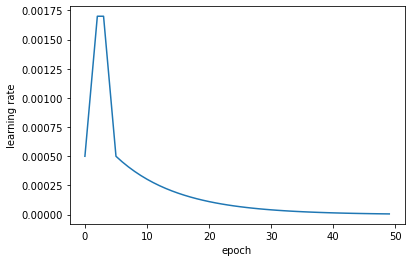

In [88]:
def learning_rate_cyclic(epoch):
    initial_lr = 0.0005
    max_lr = 0.002
    max_epochs = 5
    if epoch <= (max_epochs / 2):
        lr = initial_lr + (max_lr-initial_lr) * epoch/(max_epochs/2)
        return lr
    if (epoch > (max_epochs / 2)) & (epoch < max_epochs):
        lr = max_lr - (max_lr-initial_lr) * (epoch-max_epochs/2)/(max_epochs/2)
        return lr
    else:
        lr = initial_lr*np.exp(-(epoch-max_epochs)/10)
        return lr

xrange = range(0,50)
yrange = [learning_rate_cyclic(x) for x in xrange]
plt.plot(xrange, yrange)
plt.xlabel("epoch")
plt.ylabel("learning rate")

In [89]:
epochs = 50  # This should be at least 30 for convergence
lr_schedule = tf.keras.callbacks.LearningRateScheduler(learning_rate_cyclic)
checkpoint = keras.callbacks.ModelCheckpoint(
    "models/2022-10-10-Transformer_2to2", save_best_only=True, monitor="val_loss", save_weights_only=True
)

callbacks = [lr_schedule]

transformer.summary()
transformer.compile(
    "adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds,
                          callbacks = callbacks)


Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding_2 (Positi  (None, None, 128)   108800      ['encoder_inputs[0][0]']         
 onalEmbedding)                                                                                   
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder_1 (Transfo  (None, None, 128)   791296      ['positional_embedding_

KeyboardInterrupt: 